<a href="https://colab.research.google.com/github/amalvarezme/SenalesSistemas/blob/master/3_SerieyTransformadaFourier/3_Rectificador_RC_THD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación circuito rectificador de onda completa RC

- Ver [modelado Circuito RC serie y paralelo](https://es.wikipedia.org/wiki/Circuito_RC)

Para circuito RC serie, la salida (voltaje en el capacitor) se puede calcular utilizando impedancias transformadas, como:

$V_c(s) =V_{in}(s) \frac{1}{RCs + 1}$

- Se reemplazará la entrada por una aproximación numérica de una onda cosenoidal rectificada.

- Ver [rectificador onda completa](https://es.wikipedia.org/wiki/Rectificador_de_onda_completa)

Nota: en general se estudia el circuito RC paralelo en rectificadores. El ejercicio planteado en el Taller 2 del curso, cuyo objetivo principal es ilustrar los conceptos de la transformada de Fourier, plantea el estudio del circuito RC serie, por lo que se sugiere trabajar en términos de tensión.

- Para el caso RC paralelo, se asume una fuente de corriente como entrada y la salida en tensión en el capacitor (ver última sección  [modelado Circuito RC serie y paralelo](https://es.wikipedia.org/wiki/Circuito_RC)). Utilizando impedancias transformadas, se tiene que:

$V_c(s) =I_{in}(s) \frac{R}{RCs + 1}$

In [1]:
#paquetes de para simulación
import numpy as np
import scipy
import matplotlib.pyplot as plt
#%matplotlib inline
import scipy.signal as sig
import scipy.optimize as opt
#from IPython.display import Image
import sympy as sym 
#sym.init_session() 

# Modelo en Laplace circuito RC serie utilizando impedancias transformadas

- Según los modelos descritos anteriormente, se plantea la función de transferencia usando `sympy`.

# Funcion de transferencia

In [2]:
s = sym.symbols('s', complex=True)
t, R, L, C = sym.symbols('t R L C', positive=True)
X = sym.Function('X')(s)

Y = 1/(R*C*s + 1) * X
Y

X(s)/(C*R*s + 1)

# Fijar valores de parámetros para simulación

- Se fijan los valores de resistencia y capacitancia para la simulación:

In [3]:
R_v = 1000 #valores de simulacion de R
C_v =  10e-6 # valores de simulacion de C
Y_RC = Y.subs(R, R_v).subs(C, C_v)
Y_RC

X(s)/(0.01*s + 1)

#Función de transferencia en scipy 

- Se resuelve la función de transferencia y se pasa al paquete scipy para trabajar con la aproximación numérica de la entrada, en este caso la función senoidal rectificada

- Par más información ver [Función de Transferencia scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.TransferFunction.html)

In [4]:
num = np.array([1]) #coeficientes del numerador de la funcion de transferencia como numpy array
den = np.array([R_v*C_v,1])#coeficientes del denominador de la funcion de transferencia como numpy array
G_n = sig.TransferFunction(num, den) #funcion de transferencia en
print(num)
print(den)

[1]
[0.01 1.  ]


# Evaluar el sistema ante entrada de interés y obtener salida en arreglo numpy

In [5]:
Fo = 60 #frec alimentación
Fs = 30*Fo #frecuencia muestreo
To = 1/Fo #periodo fundamental
Ts = 1/Fs #periodo muestreo
t = np.arange(0, 5*To,Ts) # se simulan 5 peridos de alimentación con un muestreo segun Ts
A = 120 #amplitud entrada
#función de entrada aproximada como onda senoidal rectificada completa
in_o = A*(np.sin(2*np.pi*Fo*t))
rec_c = sig.square(2*np.pi*Fo*t)#función tren de pulsos para simular señal rectificada 
#Para rectificador de media onda: 
rec_m = 0.5*(sig.square(2*np.pi*Fo*t)+1)
in_ = in_o * rec_c #si se quiere probar con rec media onda multiplicar por rec_m
out = G_n.output(in_, T=t)[1] #evaluar salida ante entrada rectificada mediante aproximacion numérica de scipy

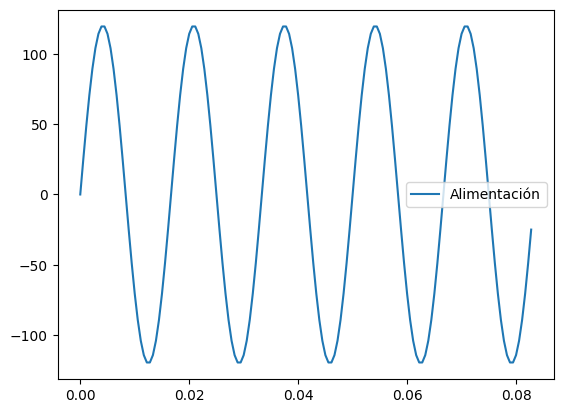

In [6]:
#señales de alimentación y tren de pulsos
plt.plot(t,in_o,label='Alimentación')
plt.legend()
plt.show()

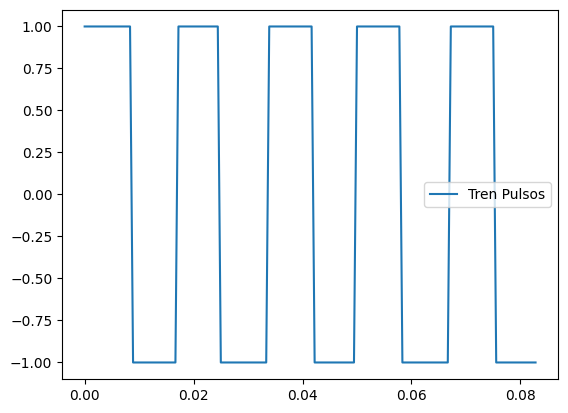

In [7]:
plt.plot(t,rec_c,label='Tren Pulsos')
plt.legend()
plt.show()

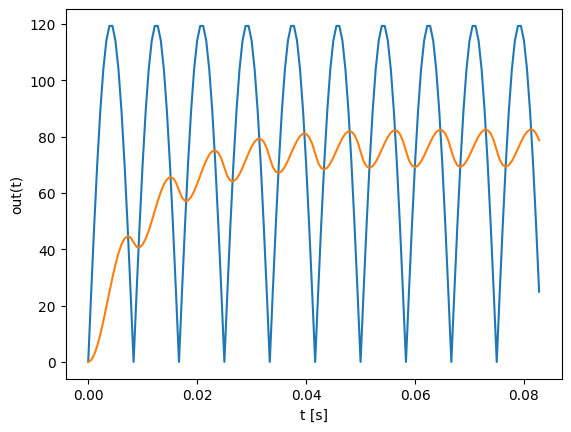

In [8]:
plt.plot(t, in_,label='In(t)')#entrada rectificada
plt.plot(t, out,label='Out(t)')#salida del circuito
plt.xlabel('t [s]')
plt.ylabel('out(t)')
plt.show()

#Cálculo del espectro con fft

Nota: Debe tener presente el valor de $F_s$ y $F_o$ para el análisis de los armónicos

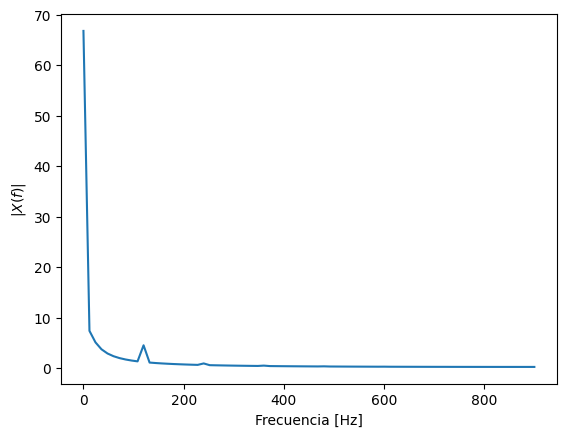

In [9]:
vfre = np.fft.rfftfreq(len(out),1/Fs) #vector de frecuencia en Hz segun tamaño del vector y tiempo de muestreo
Xf = np.fft.rfft(out)

plt.plot(vfre,abs(Xf/len(out)))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('$|X(f)|$')
plt.show()

# Cálculo de la distorsión total de armónicos - THD

- Con los valores de frecuencia en Hz y el espectro cálculado como arreglo de numpy, se puede calcular la [distorsión total de armónicos (THD)](https://en.wikipedia.org/wiki/Total_harmonic_distortion), según:

$$THD = \frac{\sqrt{V_2+V_3+\cdots V_n}}{V_1}$$

donde $V_n$ es el valor del $n$-th armónico de la señal de salida del circuito (en términos de tensión) y $V_1$ es la componente (armónico fundamental).

- Además, la medida de [distorsión del factor de potencia](https://eepower.com/technical-articles/total-harmonic-distortion-thd-and-power-factor-calculation/#) se puede calcular desde el THD, como:

$$PF_{THD}=\sqrt{\frac{1}{1+(THD)^2}}$$
